In [ ]:
!pip install transformers torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pip install datasets
!pip install rouge-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=a180601079892fe20427d3a7990e5a6

In [ ]:
import torch
from transformers import GPT2LMHeadModel, AutoTokenizer
from datasets import load_dataset
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
nltk.download("punkt")
nltk.download("punkt_tab")

smoothie = SmoothingFunction().method4

# List of models to compare
models = {
    "GPT-2": "openai-community/gpt2",
    "DialoGPT-small": "microsoft/DialoGPT-small",
    "DialoGPT-gpt2-TA": "amitom/DialoGPT-gpt2-TA",
    "DialoGPT-gpt2-SLERP": "amitom/gpt2-DiabloGPT-SLERP",
    "Dialogpt-gpt2-Ties": "amitom/DialoGPT-gpt2-TIES",
    "Dialogpt-gpt2-Passthrough": "amitom/DialoGPT-gpt2-Passthrough"
}


print("Loading dataset...")
dataset = load_dataset("daily_dialog", split="validation", trust_remote_code=True)
text_samples = dataset["dialog"][:200]

flattened_text_samples = [sentence for dialogue in text_samples for sentence in dialogue]


def calculate_perplexity(model, tokenizer, sentences, max_tokens=1000):
    encodings = tokenizer("\n".join(sentences), return_tensors="pt", truncation=True, max_length=max_tokens)
    input_ids = encodings["input_ids"]

    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss

    total_loss = loss.item() * input_ids.shape[1]
    total_tokens = input_ids.shape[1]
    avg_loss = total_loss / total_tokens
    perplexity = torch.exp(torch.tensor(avg_loss))
    return perplexity.item()

def generate_response(model, tokenizer, prompt, max_new_tokens=30):
    input_ids = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).input_ids
    output_ids = model.generate(input_ids, max_new_tokens=max_new_tokens, pad_token_id=tokenizer.eos_token_id, temperature=0.7, top_p=0.9)
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return output_text[len(prompt):].strip()

def evaluate_bleu(model, tokenizer, dialogues, max_samples=100):
    scores = []
    for dialogue in dialogues[:max_samples]:
        if len(dialogue) < 2:
            continue
        context = " ".join(dialogue[:-1])
        reference = nltk.word_tokenize(dialogue[-1])
        generated = generate_response(model, tokenizer, context)
        hypothesis = nltk.word_tokenize(generated)
        score = sentence_bleu([reference], hypothesis, smoothing_function=smoothie)
        scores.append(score)
    return sum(scores) / len(scores)

def evaluate_mmlu(model, tokenizer, mmlu_dataset, max_samples=85):
    correct_answers = 0
    for sample in mmlu_dataset.select(range(max_samples)):
        question = sample['question']
        choices = sample['choices']
        correct_answer_index = sample['answer']

        prompt = f"Question: {question}\nChoices: {', '.join(choices)}\nAnswer:"

        generated_answer = generate_response(model, tokenizer, prompt)

        print(f"Question: {question}")
        print(f"Generated: {generated_answer.strip()}")
        print(f"Correct: {choices[correct_answer_index]}")

        if generated_answer.strip().lower() == choices[correct_answer_index].lower():
            correct_answers += 1

    accuracy = correct_answers / max_samples
    return accuracy

def evaluate_rouge(model, tokenizer, dialogues, max_samples=100):
    scores = []
    for dialogue in dialogues[:max_samples]:
        if len(dialogue) < 2:
            continue
        context = " ".join(dialogue[:-1])
        reference = dialogue[-1]
        generated = generate_response(model, tokenizer, context)

        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        score = scorer.score(reference, generated)
        scores.append(score)

    avg_rouge = {
        'rouge1': sum([score['rouge1'].fmeasure for score in scores]) / len(scores),
        'rouge2': sum([score['rouge2'].fmeasure for score in scores]) / len(scores),
        'rougeL': sum([score['rougeL'].fmeasure for score in scores]) / len(scores)
    }
    return avg_rouge

rouge_scores = {}
perplexity_scores = {}
bleu_scores = {}

for name, model_path in models.items():
    print(f"\nLoading {name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
    model = GPT2LMHeadModel.from_pretrained(model_path)
    model.eval()

    # Perplexity
    print("Calculating perplexity...")
    perplexity = calculate_perplexity(model, tokenizer, flattened_text_samples)
    perplexity_scores[name] = perplexity

    # BLEU
    print("Calculating BLEU score...")
    bleu = evaluate_bleu(model, tokenizer, text_samples)
    bleu_scores[name] = bleu

    # ROUGE
    print("Calculating ROUGE score...")
    rouge = evaluate_rouge(model, tokenizer, text_samples)
    rouge_scores[name] = rouge

# Output results
print("\nModel Evaluation Results:")
for name in models:
    print(f"{name}: Perplexity = {perplexity_scores[name]:.2f} | BLEU = {bleu_scores[name]:.4f} | ROUGE-1 = {rouge_scores[name]['rouge1']:.4f} | ROUGE-2 = {rouge_scores[name]['rouge2']:.4f} | ROUGE-L = {rouge_scores[name]['rougeL']:.4f}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Loading dataset...


README.md:   0%|          | 0.00/7.27k [00:00<?, ?B/s]

daily_dialog.py:   0%|          | 0.00/4.85k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11118 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Loading MMLU dataset...


README.md:   0%|          | 0.00/53.2k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/138k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/98.6k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/3.37k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/783 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/86 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]


Loading GPT-2...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Calculating perplexity...


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Calculating BLEU score...
Calculating ROUGE score...

Loading DialoGPT-small...


tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Calculating perplexity...
Calculating BLEU score...
Calculating ROUGE score...

Loading DialoGPT-gpt2-TA...


tokenizer_config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/326M [00:00<?, ?B/s]

Calculating perplexity...
Calculating BLEU score...
Calculating ROUGE score...

Loading DialoGPT-gpt2-SLERP...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/925 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/326M [00:00<?, ?B/s]

Calculating perplexity...
Calculating BLEU score...
Calculating ROUGE score...

Loading Dialogpt-gpt2-Ties...


tokenizer_config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/326M [00:00<?, ?B/s]

Calculating perplexity...
Calculating BLEU score...
Calculating ROUGE score...

Loading Dialogpt-gpt2-Passthrough...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/881 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/411M [00:00<?, ?B/s]

Calculating perplexity...
Calculating BLEU score...
Calculating ROUGE score...

Model Evaluation Results:
GPT-2: Perplexity = 22.73 | BLEU = 0.0204 | ROUGE-1 = 0.0873 | ROUGE-2 = 0.0179 | ROUGE-L = 0.0811
DialoGPT-small: Perplexity = 22264.01 | BLEU = 0.0017 | ROUGE-1 = 0.0033 | ROUGE-2 = 0.0000 | ROUGE-L = 0.0030
DialoGPT-gpt2-TA: Perplexity = 7867.72 | BLEU = 0.0001 | ROUGE-1 = 0.0006 | ROUGE-2 = 0.0000 | ROUGE-L = 0.0006
DialoGPT-gpt2-SLERP: Perplexity = 2000.73 | BLEU = 0.0027 | ROUGE-1 = 0.0105 | ROUGE-2 = 0.0020 | ROUGE-L = 0.0099
Dialogpt-gpt2-Ties: Perplexity = 33.71 | BLEU = 0.0199 | ROUGE-1 = 0.0751 | ROUGE-2 = 0.0187 | ROUGE-L = 0.0711
Dialogpt-gpt2-Passthrough: Perplexity = 13126508977707777261568.00 | BLEU = 0.0000 | ROUGE-1 = 0.0000 | ROUGE-2 = 0.0000 | ROUGE-L = 0.0000


In [ ]:
new_models = {
    "DialoGPT gpt2 Ties DialoGPT Heavy" : "amitom/DialoGPT-gpt2-TIES-DialoHeavy",
    "DialoGPT gpt2 Ties gpt2 Heavy" : "amitom/DialoGPT-gpt2-TIES-gpt2Heavy"
}



for name, model_path in new_models.items():
    print(f"\nLoading {name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
    model = GPT2LMHeadModel.from_pretrained(model_path)
    model.eval()

    # Perplexity
    print("Calculating perplexity...")
    perplexity = calculate_perplexity(model, tokenizer, flattened_text_samples)
    perplexity_scores[name] = perplexity

    # BLEU
    print("Calculating BLEU score...")
    bleu = evaluate_bleu(model, tokenizer, text_samples)
    bleu_scores[name] = bleu

    # ROUGE
    print("Calculating ROUGE score...")
    rouge = evaluate_rouge(model, tokenizer, text_samples)
    rouge_scores[name] = rouge

combined_models = {**models, **new_models}

print("\nModel Evaluation Results:")
for name in combined_models:
    print(f"{name}: Perplexity = {perplexity_scores[name]:.2f} | BLEU = {bleu_scores[name]:.4f} | ROUGE-1 = {rouge_scores[name]['rouge1']:.4f} | ROUGE-2 = {rouge_scores[name]['rouge2']:.4f} | ROUGE-L = {rouge_scores[name]['rougeL']:.4f}")


Loading DialoGPT gpt2 Ties DialoGPT Heavy...


tokenizer_config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/326M [00:00<?, ?B/s]

Calculating perplexity...
Calculating BLEU score...
Calculating ROUGE score...

Loading DialoGPT gpt2 Ties gpt2 Heavy...


tokenizer_config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/326M [00:00<?, ?B/s]

Calculating perplexity...
Calculating BLEU score...
Calculating ROUGE score...

Model Evaluation Results:
GPT-2: Perplexity = 22.73 | BLEU = 0.0204 | ROUGE-1 = 0.0873 | ROUGE-2 = 0.0179 | ROUGE-L = 0.0811
DialoGPT-small: Perplexity = 22264.01 | BLEU = 0.0017 | ROUGE-1 = 0.0033 | ROUGE-2 = 0.0000 | ROUGE-L = 0.0030
DialoGPT-gpt2-TA: Perplexity = 7867.72 | BLEU = 0.0001 | ROUGE-1 = 0.0006 | ROUGE-2 = 0.0000 | ROUGE-L = 0.0006
DialoGPT-gpt2-SLERP: Perplexity = 2000.73 | BLEU = 0.0027 | ROUGE-1 = 0.0105 | ROUGE-2 = 0.0020 | ROUGE-L = 0.0099
Dialogpt-gpt2-Ties: Perplexity = 33.71 | BLEU = 0.0199 | ROUGE-1 = 0.0751 | ROUGE-2 = 0.0187 | ROUGE-L = 0.0711
Dialogpt-gpt2-Passthrough: Perplexity = 13126508977707777261568.00 | BLEU = 0.0000 | ROUGE-1 = 0.0000 | ROUGE-2 = 0.0000 | ROUGE-L = 0.0000
DialoGPT gpt2 Ties DialoGPT Heavy: Perplexity = 33.67 | BLEU = 0.0199 | ROUGE-1 = 0.0758 | ROUGE-2 = 0.0187 | ROUGE-L = 0.0718
DialoGPT gpt2 Ties gpt2 Heavy: Perplexity = 42.91 | BLEU = 0.0127 | ROUGE-1 = 

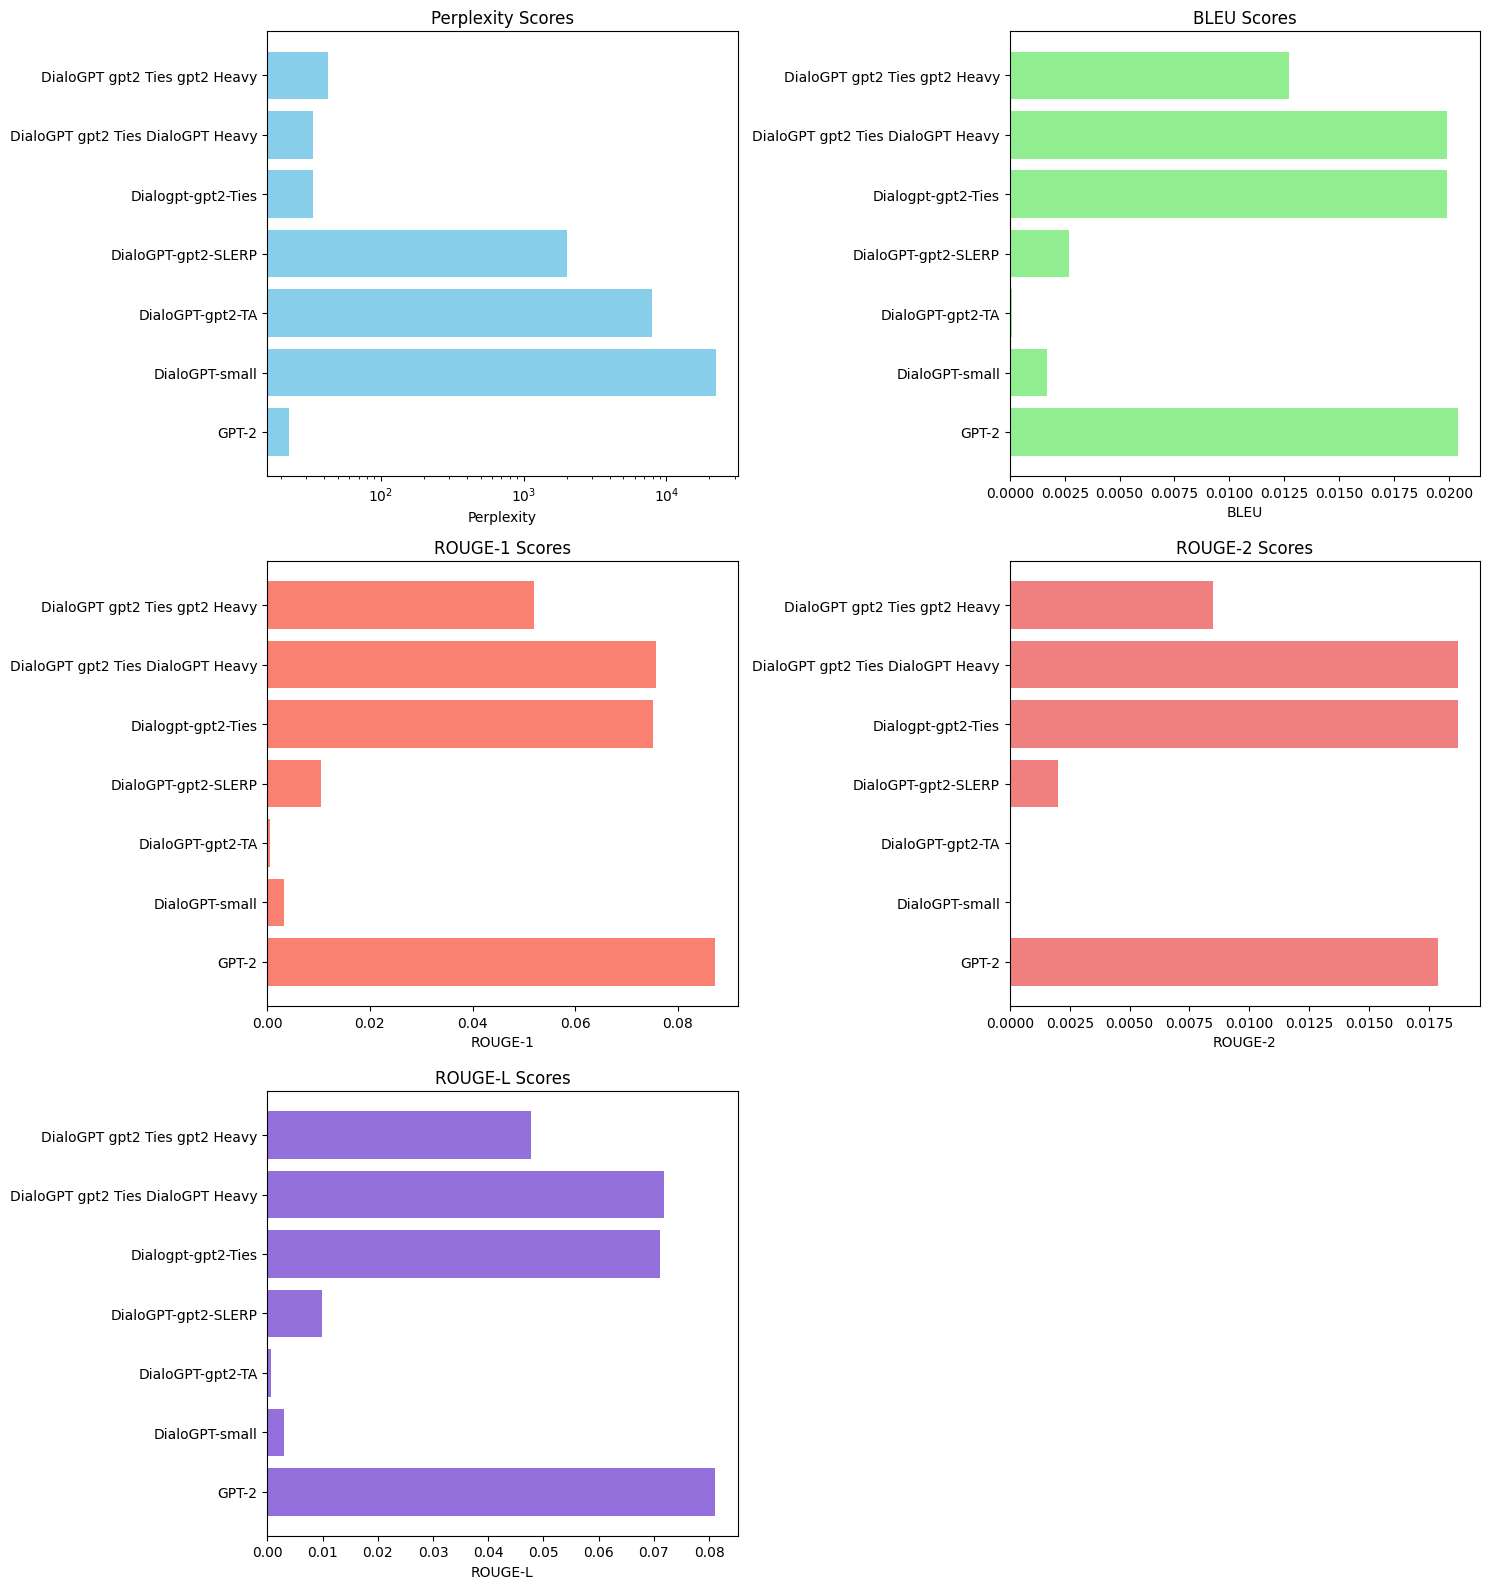

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
model_names = [
    "GPT-2", "DialoGPT-small", "DialoGPT-gpt2-TA", "DialoGPT-gpt2-SLERP", "Dialogpt-gpt2-Ties",
    "DialoGPT gpt2 Ties DialoGPT Heavy", "DialoGPT gpt2 Ties gpt2 Heavy"
]

# Scores
perplexity_scores = [22.73, 22264.01, 7867.72, 2000.73, 33.71, 33.67, 42.91]
bleu_scores = [0.0204, 0.0017, 0.0001, 0.0027, 0.0199, 0.0199, 0.0127]
rouge_1_scores = [0.0873, 0.0033, 0.0006, 0.0105, 0.0751, 0.0758, 0.0519]
rouge_2_scores = [0.0179, 0.0000, 0.0000, 0.0020, 0.0187, 0.0187, 0.0085]
rouge_L_scores = [0.0811, 0.0030, 0.0006, 0.0099, 0.0711, 0.0718, 0.0477]

# Create subplots: 3 rows, 2 columns
fig, axs = plt.subplots(3, 2, figsize=(15, 16))

axs[0, 0].barh(model_names, perplexity_scores, color='skyblue')
axs[0, 0].set_title("Perplexity Scores")
axs[0, 0].set_xlabel("Perplexity")
axs[0, 0].set_xscale('log')

axs[0, 1].barh(model_names, bleu_scores, color='lightgreen')
axs[0, 1].set_title("BLEU Scores")
axs[0, 1].set_xlabel("BLEU")

axs[1, 0].barh(model_names, rouge_1_scores, color='salmon')
axs[1, 0].set_title("ROUGE-1 Scores")
axs[1, 0].set_xlabel("ROUGE-1")

axs[1, 1].barh(model_names, rouge_2_scores, color='lightcoral')
axs[1, 1].set_title("ROUGE-2 Scores")
axs[1, 1].set_xlabel("ROUGE-2")

axs[2, 0].barh(model_names, rouge_L_scores, color='mediumpurple')
axs[2, 0].set_title("ROUGE-L Scores")
axs[2, 0].set_xlabel("ROUGE-L")

# Hide the unused subplot (bottom right)
fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()
